In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3 as sq3

In [ ]:
# Create a connection to the database
connection = sq3.connect("failure.db")

# Instantiate a custor to execute queries
cursor = connection.cursor()
# Execute a query to fetch the entire data
result = cursor.execute(
    """
    SELECT *
    FROM failure
    """
)
# Get the result of the query
data = result.fetchall()

# Define the attributes of the data
COLUMNS = [
    "Car ID", "Model", "Color", "Temperature",
    "RPM", "Factory", "Usage", "Fuel consumption",
    "Membership", "Failure A", "Failure B", "Failure C",
    "Failure D", "Failure E"
]


# Convert the data to a numpy array to use numpy's indexing
data = np.asarray(data)

# Remove the Car ID column
data = np.delete(data, 0, axis = 1)
COLUMNS.remove("Car ID")
print(data.shape)

# Check that the number of columns match the number of values in each row
assert len(data[0]) == len(COLUMNS)

(10081, 13)


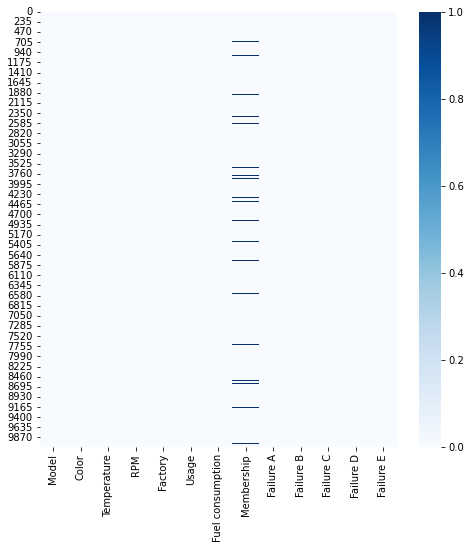

In [ ]:
# Show the distribution of NA values in the data
plt.figure(figsize = (8, 8))
sns.heatmap(
    pd.isna(data), cmap = "Blues",
    xticklabels = COLUMNS
)
plt.show()

We see all NA values are coming from the membership feature

In [ ]:
# Helper functions to retrieve column(s) from the data
get_column = lambda data, column_name: data[:, COLUMNS.index(column_name)]
get_columns = lambda data, column_idx: data[:, column_idx]

# Replace NA values with None
membership = get_column(data, "Membership")
NA_mask = pd.isna(membership)
membership[NA_mask] = "None"

# Reassign the cleaned column into the data
data[:, COLUMNS.index("Membership")] = membership

In [ ]:
# Split the columns into numerical and categorical features, and targets
target = [column for column in COLUMNS if "Failure" in column]
features = [column for column in COLUMNS if column not in target]

numerical = ["Temperature", "RPM", "Fuel consumption"]
categorical = [column for column in features if column not in numerical]

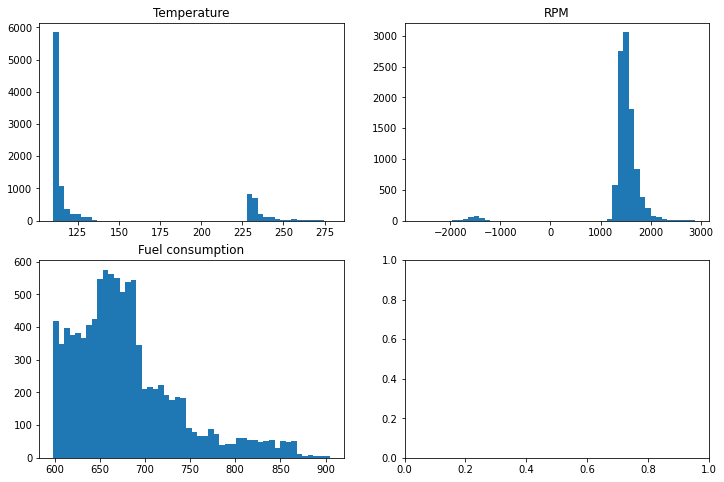

In [ ]:
# Plot the numerical features
# Note that temperature has to be cleaned first since it contains the degree celsius symbol

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 8))
flat_axs = axs.flatten()

for idx, column in enumerate(numerical):
    # Get the column needed
    subset = get_column(data, column)

    # Clean the data if the column is temperature
    if column == "Temperature":
        def clean_temperature(temp):
            return float(temp.split()[0])

        # Make clean_temperature a vectorised function to apply to an array
        clean_temperature = np.vectorize(clean_temperature)
        subset = clean_temperature(subset)

    # Plot a histogram of the column
    flat_axs[idx].hist(subset, bins = 50)
    flat_axs[idx].set_title(column)

plt.show()

For some reason, RPM has some negative values, which could indicate an error in the data handling. We should remove these rows from the data. 

We find that temperature is not a smooth distribution, and contains breaks. We should convert this feature into a binary feature denoting high and low temperature instead.

Fuel consumption seems to be roughly normally distributed, with a slight right skew. If we are using distance based classifiers like kNN or SVM, we can try applying log transformation to see if it improves the model's performance. If we are using models like decision trees however, this would not matter

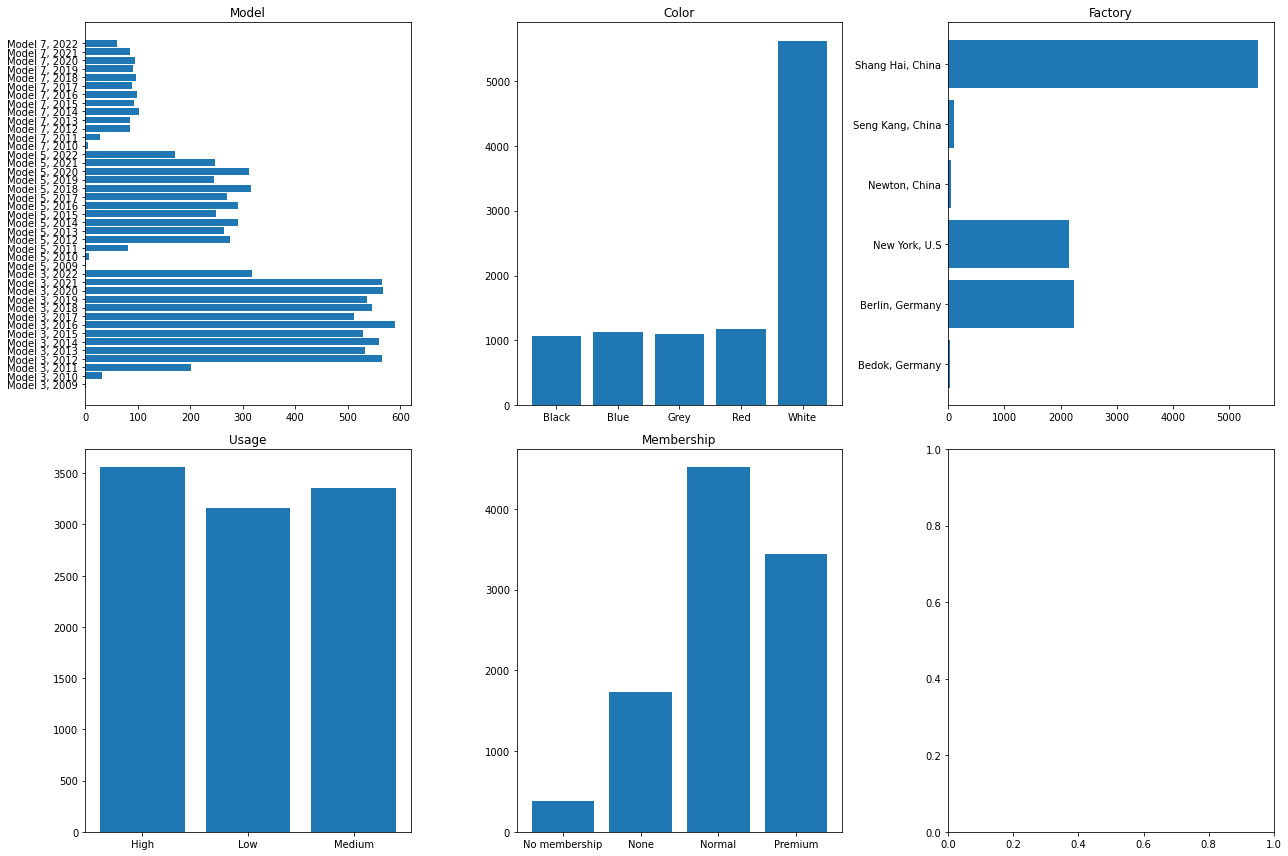

In [ ]:
# Plot the categorical features
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (18, 12))
flat_axs = axs.flatten()

for idx, column in enumerate(categorical):
    subset = get_column(data, column)
    
    # Get the unique counts of each column value to plot a bar chart
    unique, counts = np.unique(subset, return_counts = True)

    # If there are too many unique values, a vertical barchart will be too cramped
    # Plot a horizontal barchart instead
    if len(unique) > 5:
        flat_axs[idx].barh(y = unique, width = counts)
    else:
        flat_axs[idx].bar(x = unique, height = counts)
    
    flat_axs[idx].set_title(column)

plt.tight_layout()
plt.show()

In Model, there is a large number of unique models. Using one hot encoding for this feature will result in a large increase in feature space, increasing the chance our model overfits.

0


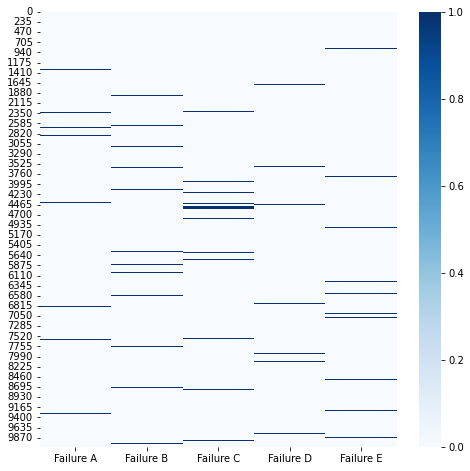

In [ ]:
# Explore the fault columns. Can a car have multiple faults?

fault_idx = [COLUMNS.index(fault) for fault in target]
fault_values = get_columns(data, fault_idx)
more_than_1_fault = (fault_values.sum(axis = 1) > 1).sum()
print(more_than_1_fault)

# Check for rows where there are overlaps. These would show whether a car can have more than 1 fault
plt.figure(figsize = (8, 8))
sns.heatmap(
    fault_values.astype(float), cmap = "Blues",
    xticklabels = target
)
plt.show()

Seems like 1 car can only have 1 type of fault. In that case, we combine all the faults into 1 column
indicating what type of fault it is